# Face Emotion Recognition (FER 2013)

In [156]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKerasTF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from collections import Counter
import itertools

## Construction du dataset à partir du dossier d'images

Le dossier d'images est disponible à cette URL : https://www.kaggle.com/datasets/msambare/fer2013?resource=download

Ce dossier contient des visages en niveau de gris, au format 48x48 pixels. 

Les données d'entrainement se composent de 28 709 exemples et les données de test se composent de 3 589 exemples.

In [1]:
def build_dataset(folder):
    """Function that returns a DataFrame of emotion + image inside a folder"""
    # List of folders names
    emotions = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
    # Dataframe
    df = pd.DataFrame(columns=["emotion","pixels"])
    for emotion in emotions:
        images = os.listdir(folder + "/" + emotion)
        for image_name in images :
            image = cv2.imread(folder + "/" + emotion + "/" + image_name) #ndarray	
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # ndarray
            # gray_list = np.reshape(gray, (1, -1)).tolist()[0]
            df2 = pd.DataFrame({"emotion":[emotion],"pixels":[gray]})
            df = pd.concat([df, df2], ignore_index=True)
    return df

In [158]:
df_train = build_dataset('./fer2013-archive/train')
df_train.head()

,emotion,pixels
0,fear,"[[244, 237, 231, 230, 232, 231, 230, 229, 229,..."
1,fear,"[[254, 252, 253, 254, 248, 253, 202, 58, 58, 5..."
2,fear,"[[231, 214, 155, 166, 171, 137, 160, 174, 181,..."
3,fear,"[[1, 0, 1, 0, 0, 1, 1, 0, 1, 112, 155, 144, 13..."
4,fear,"[[254, 254, 211, 115, 119, 103, 78, 73, 98, 12..."


In [159]:
df_test = build_dataset('./fer2013-archive/test')
df_test.head()

,emotion,pixels
0,fear,"[[255, 255, 255, 255, 255, 255, 255, 255, 254,..."
1,fear,"[[121, 178, 189, 201, 190, 161, 138, 164, 166,..."
2,fear,"[[14, 16, 24, 91, 102, 146, 147, 144, 145, 145..."
3,fear,"[[158, 159, 157, 163, 160, 99, 23, 10, 10, 11,..."
4,fear,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Distribution des données 

In [160]:
# Check target labels
df_full = pd.concat([df_train, df_test], ignore_index=True)
emotion_counts = df_full['emotion'].value_counts().reset_index()
emotion_counts

,index,emotion
0,happy,8989
1,neutral,6198
2,sad,6077
3,fear,5121
4,angry,4953
5,surprise,4002
6,disgust,547


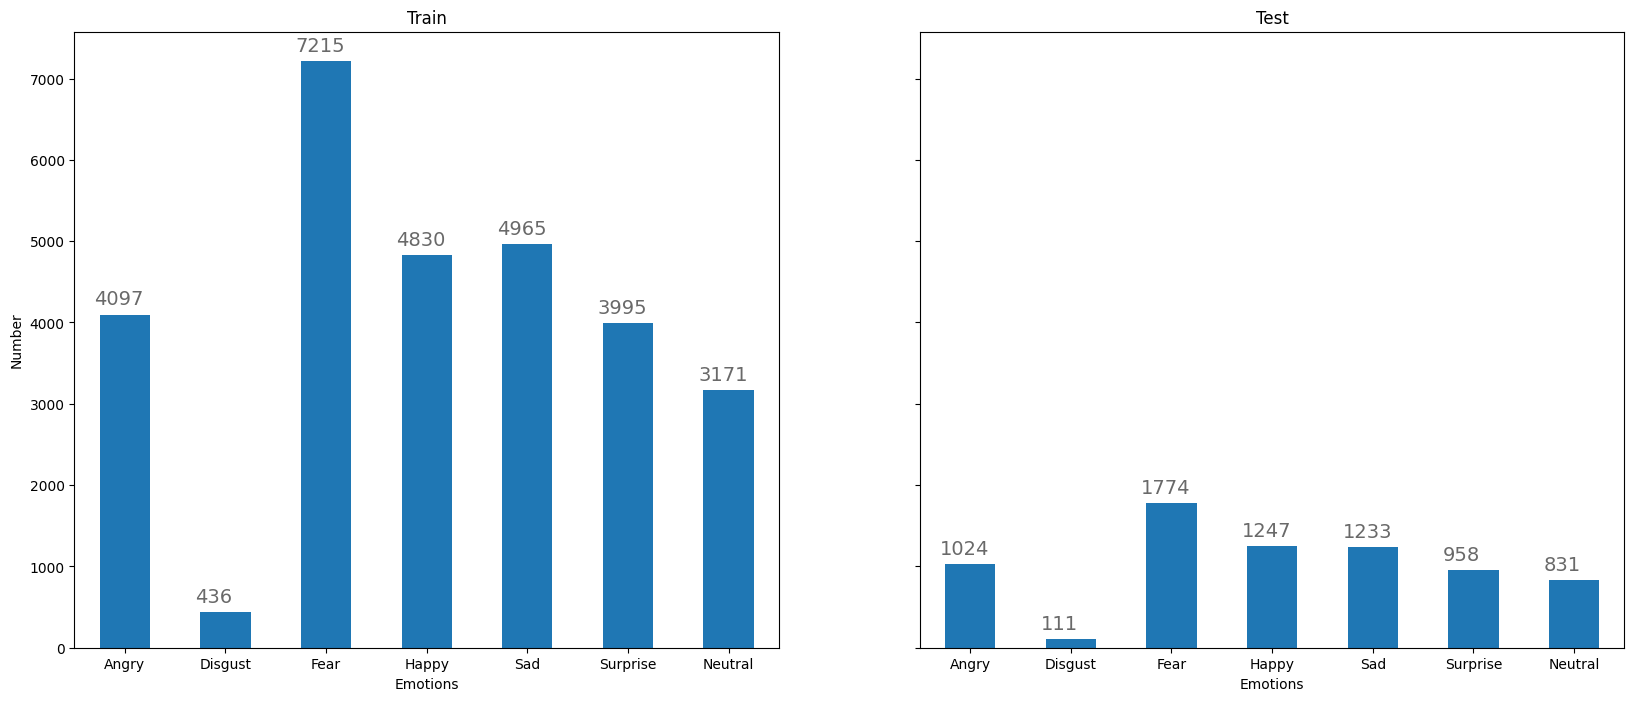

In [161]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar labels using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,2, figsize=(20,8), sharey=True)
setup_axe(axes[0],df_train,'Train')
setup_axe(axes[1],df_test,'Test')
plt.show()

## CNRO : Convert, Reshape, Normalize, One-hot encoding

In [162]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

num_classes = 7
height,width = 48, 48
emotions_map = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def CRNO(df, dataName):

    # convert, reshape and normalise grayscale image with 255.0
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0 # ndarray

    # one-hot encoding classes
    data_Y = pd.get_dummies(df['emotion'].to_list(), columns=emotions_map)

    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))

    return data_X, data_Y
    
train_X, train_Y = CRNO(df_train, "Train") #training data
test_X_full, test_Y_full   = CRNO(df_test, "Test") #test data

Train _X shape: {},  Train _Y shape: (28709, 48, 48, 1)
Test _X shape: {},  Test _Y shape: (7178, 48, 48, 1)


## Split Test et Validation

In [163]:
test_Y_full_emotions_indexes = []
# iteration
for index, row in test_Y_full.iterrows():
    # transformer les colonnes en liste
    emo_onehot_list = row.values.flatten().tolist()
    # recuperer arg max
    test_Y_full_emotions_indexes.append(np.argmax(emo_onehot_list))

In [164]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

val_X, test_X, val_Y, test_Y = train_test_split(test_X_full, test_Y_full, test_size=0.5, random_state=42, stratify=test_Y_full_emotions_indexes)

In [136]:
# Dimensions
print("Dimensions de train_X : ", train_X.ndim)
print("Dimensions de val_X : ", val_X.ndim)
print("Dimensions de test_X : ", test_X.ndim)

Dimensions de train_X :  4
Dimensions de val_X :  4
Dimensions de test_X :  4


In [137]:
# View the data type of tensor
print(train_X.dtype)
print(val_X.dtype)
print(test_X.dtype)

float32
float32
float32


## Afficher une image et son émotion correspondante

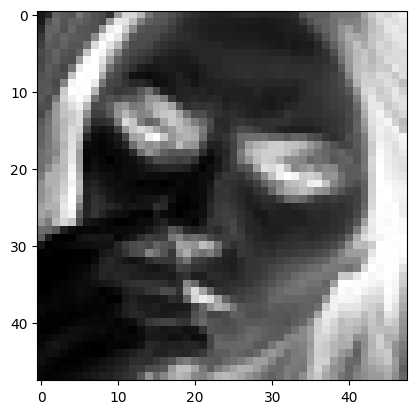

In [120]:
# Display an image
plt.imshow(train_X[2], cmap=plt.cm.binary)

## Construction du modèle CNN

### Architecture:  
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Conv -> BN -> Activation -> MaxPooling -> Dropout
* Flatten
* Dense -> BN -> Activation -> Dropout
* Dense -> BN -> Activation -> Dropout
* Dense (softmax)
* Output layer

In [121]:
import keras
from keras.models import Sequential
from keras.layers import Input,Dense, Activation, Flatten 

## Definir le modèle

In [122]:
# Initialising the CNN
model = Sequential()

# 1st - Convolution Layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Flattening
# Aplatir pour passer au réseau de neurone Dense
model.add(Flatten())

# Fully connected layer : 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Fully connected layer : 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
# Compiler le modèle avec la méthode .compile()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 128)      

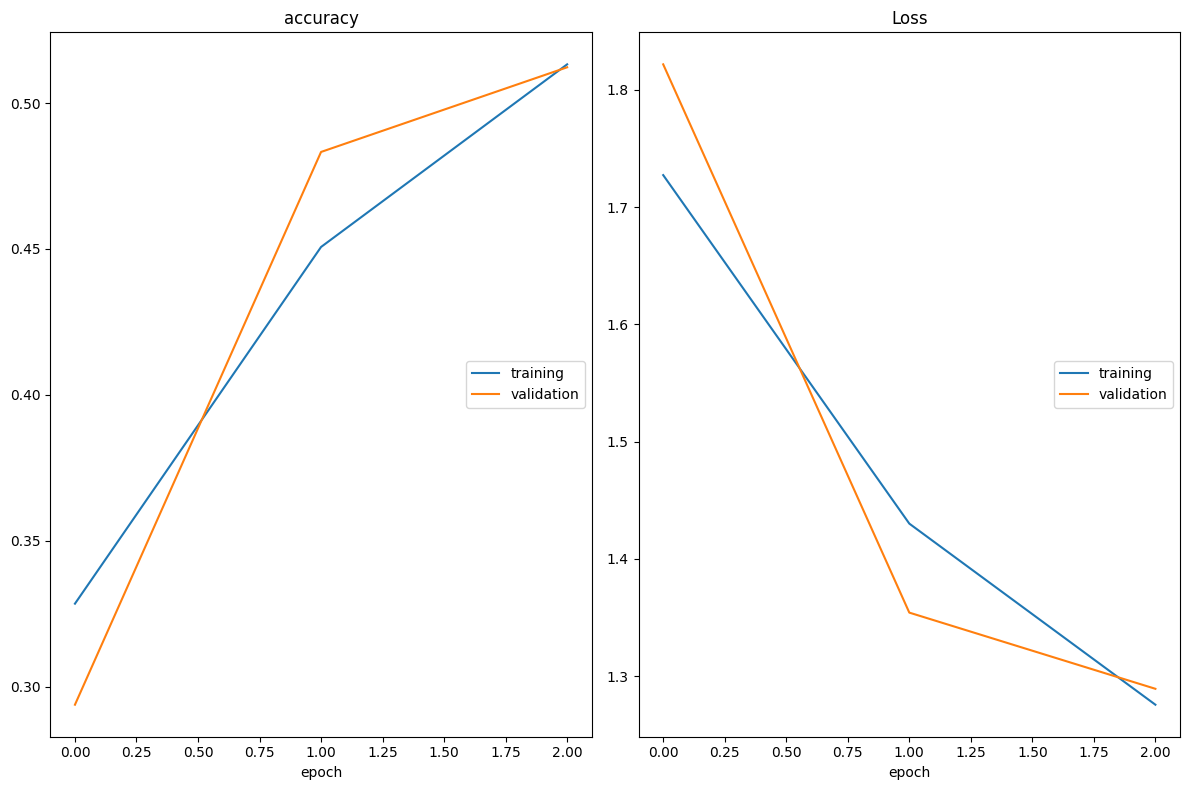

accuracy
	training         	 (min:    0.328, max:    0.513, cur:    0.513)
	validation       	 (min:    0.294, max:    0.512, cur:    0.512)
Loss
	training         	 (min:    1.276, max:    1.727, cur:    1.276)
	validation       	 (min:    1.289, max:    1.822, cur:    1.289)

Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 769s 2s/step - loss: 1.2756 - accuracy: 0.5133 - val_loss: 1.2891 - val_accuracy: 0.5123 - lr: 5.0000e-04
Epoch 4/200
356/448 [======================>.......] - ETA: 2:29 - loss: 1.1920 - accuracy: 0.5488

KeyboardInterrupt: 

In [123]:
img_size = 48
batch_size = 64

# Train
# Data Augmentation
datagen_train = ImageDataGenerator(zoom_range=0.2)
train_generator = datagen_train.flow(train_X, train_Y, batch_size=batch_size, shuffle=True)

# Val
# Data Augmentation
datagen_validation = ImageDataGenerator(zoom_range=0.2)
validation_generator = datagen_validation.flow(val_X, val_Y, batch_size=batch_size)

epochs = 200
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reducing Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Training the Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=[PlotLossesKerasTF(), reduce_lr, checkpoint]
)

## Exporter le modèle

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Importation du modèle

In [143]:
# load json and create model
json_file = open('ferams/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ferams/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


## Génerer des predictions

In [144]:
predictions = loaded_model.predict(test_X)

113/113 [==============================] - 30s 267ms/step


In [145]:
# Prediction pour l'image de test numéro 12 :
np.argmax(predictions[11])

3

In [146]:
# Emotion correspondante
emotions_map[np.argmax(predictions[11])]

'happy'

In [147]:
print(predictions[11]) # ndarray

[4.4981313e-08 1.5156240e-07 2.4627110e-07 9.9999827e-01 4.5691323e-08
 8.1031750e-09 1.1659752e-06]


In [148]:
np.sum(predictions[11])

0.99999994

## Evaluation des performances

In [170]:
test_Y

,angry,disgust,fear,happy,neutral,sad,surprise
6845,0,0,0,0,0,0,1
3926,0,0,0,0,0,1,0
153,0,0,1,0,0,0,0
2631,0,0,0,1,0,0,0
2012,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
7038,0,0,0,0,0,0,1
642,0,0,1,0,0,0,0
5517,1,0,0,0,0,0,0
144,0,0,1,0,0,0,0


In [171]:
test_true = np.argmax(test_Y.to_numpy(), axis=1)
test_pred = np.argmax(loaded_model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 29s 216ms/step
CNN Model Accuracy on test set: 0.3996


## Matrice de confusion

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [172]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

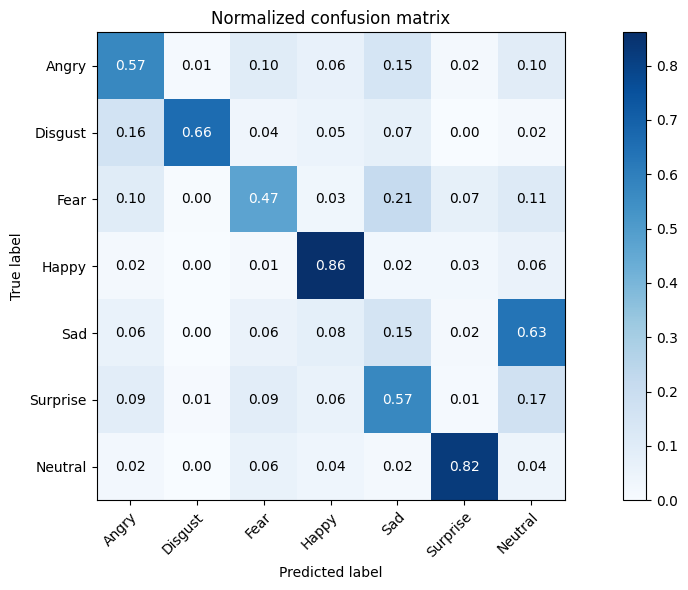

In [173]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

## Analysis using Precision, Recall and F1-Score


Precision : Percent of positive predictions made which were correct

    precision = True positives / (True positives + False positives)

Recall : Percent of Actual positive values were correctly classified by your classifier

    recall = True positives / (True positives + False negatives)

F1-Score : It is harmonic mean of precision and recall.

    f1-score = (2 * precision * recall) / (precision + recall)

In [174]:
print(classification_report(test_true, test_pred, target_names=emotion_labels))

              precision    recall  f1-score   support

       Angry       0.61      0.57      0.59       479
     Disgust       0.74      0.66      0.70        56
        Fear       0.58      0.47      0.52       512
       Happy       0.83      0.86      0.85       887
         Sad       0.14      0.15      0.15       616
    Surprise       0.02      0.01      0.02       624
     Neutral       0.03      0.04      0.03       415

    accuracy                           0.40      3589
   macro avg       0.42      0.40      0.41      3589
weighted avg       0.41      0.40      0.40      3589

